In [ ]:
!nvidia-smi

Tue Sep  7 03:56:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import zipfile
import tensorflow as tf
import cv2
import random
import matplotlib.pyplot as plt
import os
from keras.callbacks import ReduceLROnPlateau
import matplotlib.image as mpimg
from tqdm import tqdm
 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [ ]:
!cp /content/drive/MyDrive/Colab\ Notebooks/AAIC/2nd\ case\ study/Cornell-dataset.zip /content/Cornell-dataset.zip
with zipfile.ZipFile('/content/Cornell-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/cornell_grasping_dataset/')

In [ ]:
train = np.load('/content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/train.npy',allow_pickle=True)
test = np.load('/content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/test1.npy',allow_pickle=True)
 
from sklearn.model_selection import train_test_split
train,_ = train_test_split(train,stratify=train[:,2],test_size=0.8,random_state=4444)
test,_ = train_test_split(test,stratify=test[:,2],test_size=0.60,random_state=4444)
 
len(train),len(test)

(84075, 8744)

In [ ]:
!mkdir /content/tempimages
class Dataset:
    def __init__(self,df):
        self.df = df
 
 
    def bboxes_to_grasps(self,box):
        # converting and scaling bounding boxes into grasps, g = {x, y, tan, h, w}
        x = (box[0][0] + (box[2][0] - box[0][0])/2)
        y = (box[0][1] + (box[2][1] - box[0][1])/2)
        tan =(box[2][0] -box[3][0]) / (box[2][1] -box[3][1])
        w = np.sqrt(np.power((box[1][0] - box[0][0]), 2) + np.power((box[1][1] -box[0][1]), 2))
        h = np.sqrt(np.power((box[3][0] -box[0][0]), 2) + np.power((box[3][1] -box[0][1]), 2))
        return round(x,3), round(y,3), 360 - (np.rad2deg(np.arctan(round(tan,3) )) + 90), round(h,3), round(w,3)
 
    # Reverse function
    def grasp_to_bbox_pred(self,x, y, angle, h, w):
        edge1 = (x - w/2, y + h/2)
        edge2 = (x + w/2, y + h/2)
        edge3 = (x + w/2, y - h/2)
        edge4 = (x - w/2, y - h/2)
        a = np.array([edge1, edge2, edge3, edge4])
        a = a - (x,y)
        angle = angle * (3.14/180)
        fun = lambda x: (x[:,0] * np.cos(angle) - x[:,1] * np.sin(angle), x[:,0] * np.sin(angle) + x[:,1] * np.cos(angle))
        a = fun(a)
        a = np.array(a).T
        a = a + (x,y)
        return a
 
    def __getitem__(self, i):
        if os.path.isfile(f"/content/tempimages/temp{self.df[i][1]}_1.npy") :
            image = np.load(f"/content/tempimages/temp{self.df[i][1]}_1.npy")
            depth = np.load(f"/content/tempimages/temp{self.df[i][1]}_2.npy")
            return ((tf.convert_to_tensor(image),tf.convert_to_tensor(depth)),tf.convert_to_tensor(np.load(f"/content/tempimages/temp{self.df[i][1]}_3.npy")))
        else:
            path = self.df[i][0]
            image=cv2.imread(path, cv2.COLOR_BGR2RGB)
            box = self.df[i][7]
            depth = cv2.imread(path.replace('r.png','d.png'), cv2.IMREAD_GRAYSCALE)


            # # randome translating image
            height, width = image.shape[:2]
            tt,ttt =  self.df[i][4],self.df[i][5]
            T = np.float32([[1, 0, 50 * tt], [0, 1, 50 * ttt]])
            image = cv2.warpAffine(image, T, (width, height))
            depth = cv2.warpAffine(depth, T, (width, height))

            # poin tranlation
            box = box + np.array([50 * tt,50 * ttt])

            # Rotate Image
            angle = self.df[i][6]
            image_center = tuple(np.array(image.shape[1::-1]) / 2)
            rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
            image = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
            depth = cv2.warpAffine(depth, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)

            # rotate point
            box = box - image_center
            angle = angle * -1
            angle = angle * (3.14/180)
            fun = lambda x: (x[:,0] * np.cos(angle) - x[:,1] * np.sin(angle), x[:,0] * np.sin(angle) + x[:,1] * np.cos(angle))
            box = fun(box)
            box = np.array(box).T
            box = box + image_center
            


            x, y, tan, h, w = self.bboxes_to_grasps(box)
            depth = cv2.cvtColor(depth,cv2.COLOR_GRAY2RGB)
 
            np.save(f"/content/tempimages/temp{self.df[i][1]}_1.npy",image)
            np.save(f"/content/tempimages/temp{self.df[i][1]}_2.npy",depth)
            np.save(f"/content/tempimages/temp{self.df[i][1]}_3.npy",np.round(np.array([x, y, tan, h, w]),2))
 
            return ((tf.convert_to_tensor(image),tf.convert_to_tensor(depth)),tf.convert_to_tensor(np.round(np.array([x, y, tan, h, w]),2)))
 
        
 
    def __len__(self):
        return len(self.df)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(dataset))
 
    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        rgb = []
        depth = []
        dim = []
        for j in range(start, stop):
            rgb.append(self.dataset[j][0][0])
            depth.append(self.dataset[j][0][1])
            dim.append(self.dataset[j][1])

            
        
        rgb = np.array(rgb)
        depth = np.array(depth)
        dim = np.array(dim)

        return tuple([tuple([rgb,depth]),dim])
        
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [ ]:
BATCH_SIZE = 128
train_dataset = Dataset(train)
train_dataloader = Dataloder(train_dataset,batch_size=BATCH_SIZE)
 
test_dataset = Dataset(test)
test_dataloader = Dataloder(test_dataset,batch_size=BATCH_SIZE)

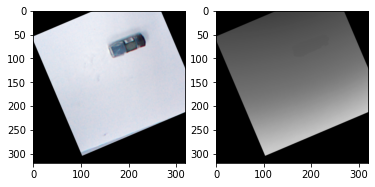

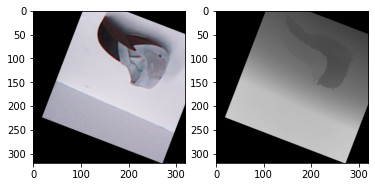

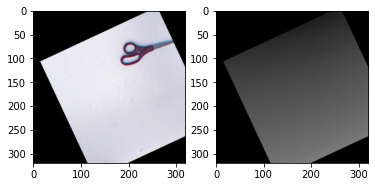

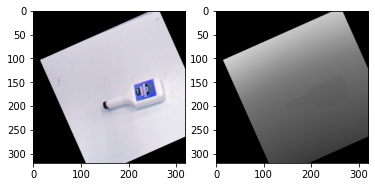

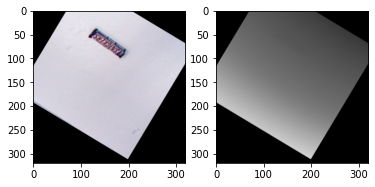

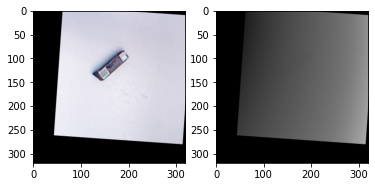

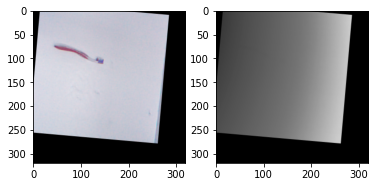

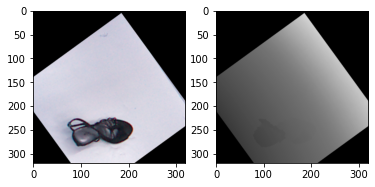

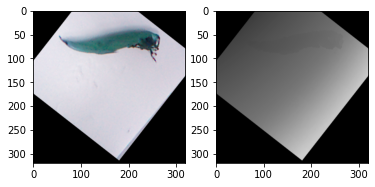

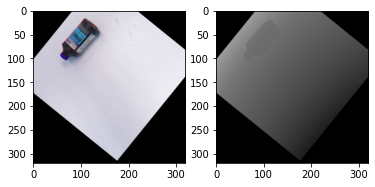

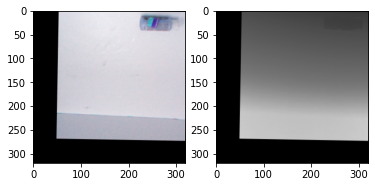

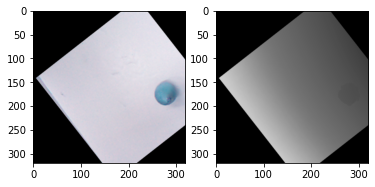

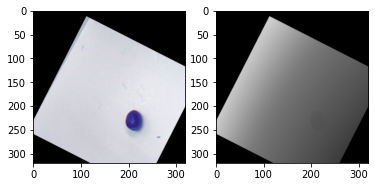

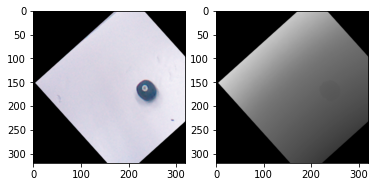

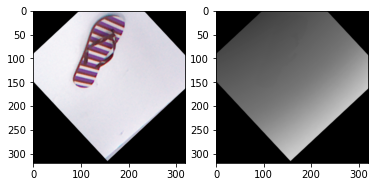

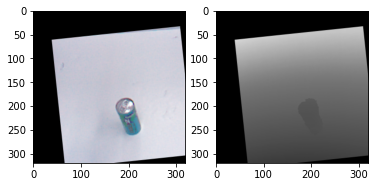

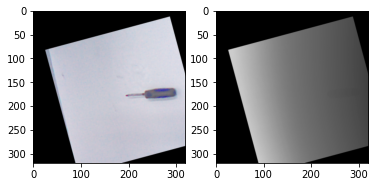

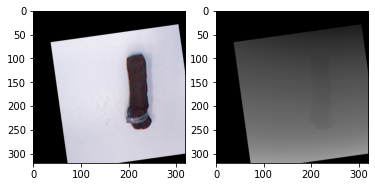

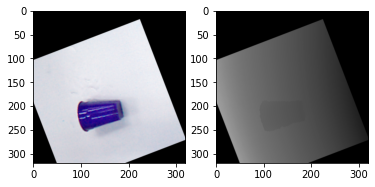

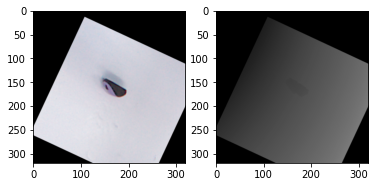

In [ ]:
for i in range(20):
    i = random.randint(0,len(train_dataloader)-1)
    fig,(ax1,ax2)= plt.subplots(1,2)
 
    j = random.randint(0,127)
    loader = train_dataloader[i]
    ax1.imshow(loader[0][0][j])
    ax2.imshow(loader[0][1][j])

In [3]:
##Source: https://stackoverflow.com/a/57247833/8211103
from shapely.geometry import Polygon
def calculate_iou(data):
    box_1 = [[data[0],data[1]],[data[2],data[3]],[data[4],data[5]],[data[6],data[7]]]
    box_2 = [[data[8],data[9]],[data[10],data[11]],[data[12],data[13]],[data[14],data[15]]]
 
    poly_1 = Polygon(box_1)
    poly_2 = Polygon(box_2)
    iou = (poly_1.intersection(poly_2).area / poly_1.union(poly_2).area) * 100
    return np.ndarray.astype(np.array(iou),np.float32)
 
def grasp_to_bbox(x1, y1, tan1, h1, w1):
    lst = []
    
    fun = lambda x: (x[:,0] * np.cos(angle) - x[:,1] * np.sin(angle), x[:,0] * np.sin(angle) + x[:,1] * np.cos(angle))
    for i in range(len(x1)):
        x = x1[i]
        y = y1[i]
        tan = tan1[i]
        h = h1[i]
        w = w1[i]
 
 
        angle = tan * (3.14/180)
        edge1 = (x - w/2, y + h/2)
        edge2 = (x + w/2, y + h/2)
        edge3 = (x + w/2, y - h/2)
        edge4 = (x - w/2, y - h/2)
 
        a = np.array([edge1, edge2, edge3, edge4])
        
        a = a - (x,y)
        a = fun(a)
        
        a = np.array(a).T
        
        a = a + (x,y)
        lst.append(a.reshape(1,-1)[0])
    return tf.convert_to_tensor(np.array(lst))
 
def Accuracy(y_train, y_pred):
    # a = tf.square(y_train[:,:2] - y_pred[:,:2])
    # a = tf.sqrt(tf.add(a[:,0], a[:,1]))
    # a = tf.cast(tf.less(a,10),tf.int8)
 
    b = tf.abs(y_train[:,2] - y_pred[:,2])
    b = tf.cast(tf.less(b,30),tf.int8)
    
 
    ## IOU
    f = tf.py_function(grasp_to_bbox,[y_train[:,0],y_train[:,1],y_train[:,2],y_train[:,3],y_train[:,4]],Tout=tf.float32)
    f1 = tf.py_function(grasp_to_bbox,[y_pred[:,0],y_pred[:,1],y_pred[:,2],y_pred[:,3],y_pred[:,4]],Tout=tf.float32)
 
 
    final = tf.concat([f, f1],axis=1)
    fun = lambda x : tf.py_function(calculate_iou,[x],Tout=tf.float32)
    iou = tf.map_fn(fun, final)
    iou = tf.cast(tf.greater(iou,25),tf.int8)
    
 
    # score = tf.reduce_mean(tf.add(tf.add(a,b),iou)/3)
    score = tf.reduce_mean(tf.add(b,iou)/2)
 
    return score
 
import tensorflow.keras.backend as K
def get_model(lr = 0.001):
    model1 =  tf.keras.models.Model(RESNET501.input,RESNET501.output)
    model2 =  tf.keras.models.Model(RESNET502.input,RESNET502.output)

    resnet = tf.keras.layers.concatenate(
        [
         tf.keras.layers.Lambda(lambda x: K.l2_normalize(x,axis=1))(model1.output),
         tf.keras.layers.Lambda(lambda x: K.l2_normalize(x,axis=1))(model2.output)
        ]
    )
 
    resnet = tf.keras.layers.AveragePooling2D()(resnet)
 
    x = tf.keras.layers.Flatten()(resnet)
    x = tf.keras.layers.Dense(256,activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    output = tf.keras.layers.Dense(5)(x)
    model = tf.keras.models.Model([model1.input,model2.input],output)
 
    model.compile(tf.keras.optimizers.Adam(lr), loss = 'mse')
    return model

In [ ]:
RESNET501 = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet',input_shape=(320,320,3))
for i in range(len(RESNET501.layers)):
    RESNET501.layers[i].trainable = False
    RESNET501.layers[i]._name = RESNET501.layers[i].name + "1"
 
RESNET502 = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet',input_shape=(320,320,3))
for i in range(len(RESNET502.layers)):
    RESNET502.layers[i].trainable = False
    RESNET502.layers[i]._name = RESNET502.layers[i].name + "2"
 
model = get_model()

model.summary()
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True
)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
BATCH_SIZE = 128
train_dataset = Dataset(train)
train_dataloader = Dataloder(train_dataset,batch_size=BATCH_SIZE)
 
test_dataset = Dataset(test)
test_dataloader = Dataloder(test_dataset,batch_size=BATCH_SIZE)
 
# filepath="/content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50-multi.ckpt"
filepath="/content/RESNET50-multi.ckpt"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath,monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3,verbose = 2, min_delta = 1e-4, mode = 'min')

model.fit(train_dataloader,epochs=10,validation_data=test_dataloader,callbacks=[model_checkpoint_callback,rlr])

Epoch 1/10
656/656 [==============================] - 2548s 4s/step - loss: 16188.5166 - val_loss: 3092.2668

Epoch 00001: val_loss improved from inf to 3092.26685, saving model to /content/RESNET50-multi.ckpt
INFO:tensorflow:Assets written to: /content/RESNET50-multi.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
656/656 [==============================] - 1941s 3s/step - loss: 1409.4225 - val_loss: 772.9937

Epoch 00002: val_loss improved from 3092.26685 to 772.99365, saving model to /content/RESNET50-multi.ckpt
INFO:tensorflow:Assets written to: /content/RESNET50-multi.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/10
656/656 [==============================] - 1941s 3s/step - loss: 950.3801 - val_loss: 670.0916

Epoch 00003: val_loss improved from 772.99365 to 670.09161, saving model to /content/RESNET50-multi.ckpt
INFO:tensorflow:Assets written to: /content/RESNET50-multi.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/10
656/656 [==============================] - 1942s 3s/step - loss: 860.2955 - val_loss: 611.0383

Epoch 00004: val_loss improved from 670.09161 to 611.03833, saving model to /content/RESNET50-multi.ckpt
INFO:tensorflow:Assets written to: /content/RESNET50-multi.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/10
656/656 [==============================] - 1942s 3s/step - loss: 788.7360 - val_loss: 606.0089

Epoch 00005: val_loss improved from 611.03833 to 606.00885, saving model to /content/RESNET50-multi.ckpt
INFO:tensorflow:Assets written to: /content/RESNET50-multi.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/10
656/656 [==============================] - 1963s 3s/step - loss: 736.1077 - val_loss: 564.2201

Epoch 00006: val_loss improved from 606.00885 to 564.22009, saving model to /content/RESNET50-multi.ckpt
INFO:tensorflow:Assets written to: /content/RESNET50-multi.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/10
656/656 [==============================] - 1948s 3s/step - loss: 692.5760 - val_loss: 560.5238

Epoch 00007: val_loss improved from 564.22009 to 560.52380, saving model to /content/RESNET50-multi.ckpt
INFO:tensorflow:Assets written to: /content/RESNET50-multi.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/10
656/656 [==============================] - 1946s 3s/step - loss: 654.6586 - val_loss: 539.7300

Epoch 00008: val_loss improved from 560.52380 to 539.73004, saving model to /content/RESNET50-multi.ckpt
INFO:tensorflow:Assets written to: /content/RESNET50-multi.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/10
656/656 [==============================] - 1944s 3s/step - loss: 631.4739 - val_loss: 553.5767

Epoch 00009: val_loss did not improve from 539.73004
Epoch 10/10
656/656 [==============================] - 1942s 3s/step - loss: 607.8273 - val_loss: 547.4556

Epoch 00010: val_loss did not improve from 539.73004


In [ ]:
RESNET501 = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet',input_shape=(320,320,3))
for i in range(len(RESNET501.layers)):
    RESNET501.layers[i].trainable = False
    RESNET501.layers[i]._name = RESNET501.layers[i].name + "1"
 
RESNET502 = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet',input_shape=(320,320,3))
for i in range(len(RESNET502.layers)):
    RESNET502.layers[i].trainable = False
    RESNET502.layers[i]._name = RESNET502.layers[i].name + "2"
 
model = get_model()
model.load_weights("/content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50-multi.ckpt")
filepath="/content/RESNET50-multi.ckpt"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath,monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3,verbose = 2, min_delta = 1e-4, mode = 'min')

model.fit(train_dataloader,epochs=15,validation_data=test_dataloader,callbacks=[model_checkpoint_callback,rlr])

Epoch 1/15
656/656 [==============================] - 2588s 4s/step - loss: 629.1089 - val_loss: 520.4438

Epoch 00001: val_loss improved from inf to 520.44385, saving model to /content/RESNET50-multi.ckpt
INFO:tensorflow:Assets written to: /content/RESNET50-multi.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/15
656/656 [==============================] - 1947s 3s/step - loss: 605.3609 - val_loss: 502.2780

Epoch 00002: val_loss improved from 520.44385 to 502.27798, saving model to /content/RESNET50-multi.ckpt
INFO:tensorflow:Assets written to: /content/RESNET50-multi.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/15
656/656 [==============================] - 1947s 3s/step - loss: 585.9322 - val_loss: 508.7900

Epoch 00003: val_loss did not improve from 502.27798
Epoch 4/15
656/656 [==============================] - 1949s 3s/step - loss: 573.8287 - val_loss: 511.1260

Epoch 00004: val_loss did not improve from 502.27798
Epoch 5/15
656/656 [==============================] - 1967s 3s/step - loss: 556.4925 - val_loss: 511.3054

Epoch 00005: val_loss did not improve from 502.27798

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 6/15
656/656 [==============================] - 1946s 3s/step - loss: 497.0229 - val_loss: 455.3804

Epoch 00006: val_loss improved from 502.27798 to 455.38040, saving model to /content/RESNET50-multi.ckpt
INFO:tensorflow:Assets written to: /content/RESNET50-multi.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/15
656/656 [==============================] - 1949s 3s/step - loss: 481.5922 - val_loss: 453.0906

Epoch 00007: val_loss improved from 455.38040 to 453.09058, saving model to /content/RESNET50-multi.ckpt
INFO:tensorflow:Assets written to: /content/RESNET50-multi.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/15
656/656 [==============================] - 1948s 3s/step - loss: 472.3979 - val_loss: 447.6148

Epoch 00008: val_loss improved from 453.09058 to 447.61484, saving model to /content/RESNET50-multi.ckpt
INFO:tensorflow:Assets written to: /content/RESNET50-multi.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 9/15
656/656 [==============================] - 1949s 3s/step - loss: 465.7764 - val_loss: 446.0601

Epoch 00009: val_loss improved from 447.61484 to 446.06009, saving model to /content/RESNET50-multi.ckpt
INFO:tensorflow:Assets written to: /content/RESNET50-multi.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/15
656/656 [==============================] - 1955s 3s/step - loss: 457.0937 - val_loss: 445.1424

Epoch 00010: val_loss improved from 446.06009 to 445.14243, saving model to /content/RESNET50-multi.ckpt
INFO:tensorflow:Assets written to: /content/RESNET50-multi.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 11/15
656/656 [==============================] - 1949s 3s/step - loss: 451.9804 - val_loss: 449.3503

Epoch 00011: val_loss did not improve from 445.14243
Epoch 12/15
656/656 [==============================] - 1949s 3s/step - loss: 448.0240 - val_loss: 444.9992

Epoch 00012: val_loss improved from 445.14243 to 444.99924, saving model to /content/RESNET50-multi.ckpt
INFO:tensorflow:Assets written to: /content/RESNET50-multi.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 13/15
656/656 [==============================] - 1949s 3s/step - loss: 445.1159 - val_loss: 441.2742

Epoch 00013: val_loss improved from 444.99924 to 441.27417, saving model to /content/RESNET50-multi.ckpt
INFO:tensorflow:Assets written to: /content/RESNET50-multi.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 14/15
656/656 [==============================] - 1951s 3s/step - loss: 438.3538 - val_loss: 439.5311

Epoch 00014: val_loss improved from 441.27417 to 439.53110, saving model to /content/RESNET50-multi.ckpt
INFO:tensorflow:Assets written to: /content/RESNET50-multi.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 15/15
656/656 [==============================] - 1983s 3s/step - loss: 435.1917 - val_loss: 436.5685

Epoch 00015: val_loss improved from 439.53110 to 436.56851, saving model to /content/RESNET50-multi.ckpt
INFO:tensorflow:Assets written to: /content/RESNET50-multi.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
model.fit(train_dataloader,epochs=6,validation_data=test_dataloader,callbacks=[model_checkpoint_callback,rlr])

Epoch 1/6
656/656 [==============================] - 2007s 3s/step - loss: 430.7946 - val_loss: 433.3669

Epoch 00001: val_loss improved from 436.56851 to 433.36694, saving model to /content/RESNET50-multi.ckpt
INFO:tensorflow:Assets written to: /content/RESNET50-multi.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/6
656/656 [==============================] - 2009s 3s/step - loss: 427.4437 - val_loss: 436.5107

Epoch 00002: val_loss did not improve from 433.36694
Epoch 3/6
656/656 [==============================] - 2004s 3s/step - loss: 420.0066 - val_loss: 436.6969

Epoch 00003: val_loss did not improve from 433.36694
Epoch 4/6
656/656 [==============================] - 1962s 3s/step - loss: 417.9047 - val_loss: 434.1601

Epoch 00004: val_loss did not improve from 433.36694

Epoch 00004: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 5/6
656/656 [==============================] - 1937s 3s/step - loss: 407.4293 - val_loss: 426.4487

Epoch 00005: val_loss improved from 433.36694 to 426.44873, saving model to /content/RESNET50-multi.ckpt
INFO:tensorflow:Assets written to: /content/RESNET50-multi.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/6
656/656 [==============================] - 1968s 3s/step - loss: 404.0047 - val_loss: 425.8513

Epoch 00006: val_loss improved from 426.44873 to 425.85132, saving model to /content/RESNET50-multi.ckpt
INFO:tensorflow:Assets written to: /content/RESNET50-multi.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
RESNET501 = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet',input_shape=(320,320,3))
for i in range(len(RESNET501.layers)):
    RESNET501.layers[i].trainable = False
    RESNET501.layers[i]._name = RESNET501.layers[i].name + "1"
 
RESNET502 = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet',input_shape=(320,320,3))
for i in range(len(RESNET502.layers)):
    RESNET502.layers[i].trainable = False
    RESNET502.layers[i]._name = RESNET502.layers[i].name + "2"
 
model = get_model(4.0000001899898055e-05)
model.load_weights("/content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50-multi.ckpt")
filepath="/content/RESNET50-multi.ckpt"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath,monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3,verbose = 2, min_delta = 1e-4, mode = 'min')

model.fit(train_dataloader,epochs=5,validation_data=test_dataloader,callbacks=[model_checkpoint_callback,rlr])

94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/5
656/656 [==============================] - 2599s 4s/step - loss: 402.6293 - val_loss: 425.5243

Epoch 00001: val_loss improved from inf to 425.52429, saving model to /content/RESNET50-multi.ckpt
INFO:tensorflow:Assets written to: /content/RESNET50-multi.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
656/656 [==============================] - 1988s 3s/step - loss: 401.9467 - val_loss: 426.3125

Epoch 00002: val_loss did not improve from 425.52429
Epoch 3/5
656/656 [==============================] - 1987s 3s/step - loss: 400.4669 - val_loss: 423.9562

Epoch 00003: val_loss improved from 425.52429 to 423.95621, saving model to /content/RESNET50-multi.ckpt
INFO:tensorflow:Assets written to: /content/RESNET50-multi.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/5
656/656 [==============================] - 1988s 3s/step - loss: 397.9233 - val_loss: 425.7706

Epoch 00004: val_loss did not improve from 423.95621
Epoch 5/5
656/656 [==============================] - 1989s 3s/step - loss: 398.1086 - val_loss: 424.1755

Epoch 00005: val_loss did not improve from 423.95621


In [ ]:
model.fit(train_dataloader,epochs=5,validation_data=test_dataloader,callbacks=[model_checkpoint_callback,rlr])

Epoch 1/5
656/656 [==============================] - 1984s 3s/step - loss: 396.6833 - val_loss: 424.8233

Epoch 00001: val_loss did not improve from 423.95621
Epoch 2/5
656/656 [==============================] - 1988s 3s/step - loss: 396.6063 - val_loss: 423.6917

Epoch 00002: val_loss improved from 423.95621 to 423.69171, saving model to /content/RESNET50-multi.ckpt
INFO:tensorflow:Assets written to: /content/RESNET50-multi.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/5
656/656 [==============================] - 1986s 3s/step - loss: 396.0069 - val_loss: 423.1839

Epoch 00003: val_loss improved from 423.69171 to 423.18387, saving model to /content/RESNET50-multi.ckpt
INFO:tensorflow:Assets written to: /content/RESNET50-multi.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/5
656/656 [==============================] - 2045s 3s/step - loss: 392.5893 - val_loss: 422.2715

Epoch 00004: val_loss improved from 423.18387 to 422.27145, saving model to /content/RESNET50-multi.ckpt
INFO:tensorflow:Assets written to: /content/RESNET50-multi.ckpt/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/5
656/656 [==============================] - 2053s 3s/step - loss: 392.4025 - val_loss: 423.3127

Epoch 00005: val_loss did not improve from 422.27145


In [ ]:
def calculate_iou(data):
    box_1 = [[data[0],data[1]],[data[2],data[3]],[data[4],data[5]],[data[6],data[7]]]
    box_2 = [[data[8],data[9]],[data[10],data[11]],[data[12],data[13]],[data[14],data[15]]]
 
    poly_1 = Polygon(box_1)
    poly_2 = Polygon(box_2)
    iou = (poly_1.intersection(poly_2).area / poly_1.union(poly_2).area) * 100
    return np.ndarray.astype(np.array(iou),np.float32)

def Accuracy(y_train, y_pred):
    # a = tf.square(y_train[:,:2] - y_pred[:,:2])
    # a = tf.sqrt(tf.add(a[:,0], a[:,1]))
    # a = tf.cast(tf.less(a,10),tf.int8)
 
    b = tf.abs(y_train[:,2] - y_pred[:,2])
    b = tf.cast(tf.less(b,30),tf.int8).numpy().reshape(-1,1)
    
    
    ## IOU
    f = grasp_to_bbox(y_train[:,0],y_train[:,1],y_train[:,2],y_train[:,3],y_train[:,4])
    f1 = grasp_to_bbox(y_pred[:,0],y_pred[:,1],y_pred[:,2],y_pred[:,3],y_pred[:,4])
 
 
    final = tf.concat([f, f1],axis=1).numpy()
    iou = []
    for row in final:
        if calculate_iou(row) >25:
            iou.append(1)
        else:
            iou.append(0)
    iou = np.array(iou).reshape(-1,1)

    score = np.mean(np.sum(np.concatenate([b,iou],axis = 1),axis = 1)/2)
    return score

def score(train_dataloader):
    score = []
    for i in tqdm(range(len(train_dataloader))):
        y_pred = model.predict(train_dataloader[0][0])
        y_train =  train_dataloader[0][1]
        score.append(Accuracy(y_train, y_pred))
    return np.mean(score)

In [ ]:
score(test_dataloader)

100%|██████████| 68/68 [04:01<00:00,  3.54s/it]


0.671875

In [ ]:
score(train_dataloader)

100%|██████████| 656/656 [39:12<00:00,  3.59s/it]


0.8203125

In [ ]:
!mv /content/RESNET50-multi.ckpt /content/drive/MyDrive/Colab\ Notebooks/AAIC/2nd\ case\ study/CheckPoint/

rm: cannot remove '/content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50-multi.ckpt': No such file or directory


In [ ]:
test_dataloader.batch_size = 1
i = random.randint(0,128)
act = test_dataloader[i][1][0]
pred = model.predict(test_dataloader[i][0])[0]
act_image = (test_dataloader[i][0][0][0])
 
def grasp_to_bbox_pred(x, y, angle, h, w):
    edge1 = (x - w/2, y + h/2)
    edge2 = (x + w/2, y + h/2)
    edge3 = (x + w/2, y - h/2)
    edge4 = (x - w/2, y - h/2)
    a = np.array([edge1, edge2, edge3, edge4])
    a = a - (x,y)
    angle = angle * (3.14/180)
    fun = lambda x: (x[:,0] * np.cos(angle) - x[:,1] * np.sin(angle), x[:,0] * np.sin(angle) + x[:,1] * np.cos(angle))
    a = fun(a)
    a = np.array(a).T
    a = a + (x,y)
    return a
 
x, y, tan, h, w = act[0],act[1],act[2],act[3],act[4]
edges = grasp_to_bbox_pred(x, y, tan, h, w)
 
x = edges[:,0].reshape(1,-1)[0]
y = edges[:,1].reshape(1,-1)[0]
 
x = np.concatenate([x,x[:1]])
y = np.concatenate([y,y[:1]])
 
im = act_image
fig, ax = plt.subplots(figsize = (12,12))
ax.imshow(im)
ax.plot(x,y, 'ro-',color = 'green')
 
 
x, y, tan, h, w = pred[0],pred[1],pred[2],pred[3],pred[4]
edges = grasp_to_bbox_pred(x, y, tan, h, w)
 
x = edges[:,0].reshape(1,-1)[0]
y = edges[:,1].reshape(1,-1)[0]
 
x = np.concatenate([x,x[:1]])
y = np.concatenate([y,y[:1]])
 
 
ax.plot(x,y, 'ro-')
 
plt.show()

In [4]:
RESNET501 = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet',input_shape=(320,320,3))
for i in range(len(RESNET501.layers)):
    RESNET501.layers[i].trainable = False
    RESNET501.layers[i]._name = RESNET501.layers[i].name + "1"
 
RESNET502 = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet',input_shape=(320,320,3))
for i in range(len(RESNET502.layers)):
    RESNET502.layers[i].trainable = False
    RESNET502.layers[i]._name = RESNET502.layers[i].name + "2"
 
model = get_model()
model.load_weights("/content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/CheckPoint/RESNET50-multi.ckpt")


model.save_weights("/content/drive/MyDrive/Colab Notebooks/AAIC/2nd case study/Models/RESNET50-multi.h5")

94781440/94765736 [==============================] - 1s 0us/step
